In [7]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from wordcloud import WordCloud

#download necessary NLP resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siddi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\siddi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [11]:
df = pd.read_csv('Emails.csv')
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [13]:
print("Missing values:", df.isnull().sum())


Missing values: text    0
spam    0
dtype: int64


In [19]:
print("class Distribution:", df['spam'].value_counts())

class Distribution: spam
0    4360
1    1368
Name: count, dtype: int64


In [42]:
# Additional custom stopwords (including meaningless words like 'aa', 'aaa', 'ab')
custom_stopwords = set(['aa', 'aaa', 'ab', 'ac',])

In [47]:


def preprocess_text(text):
    # Remove "Subject:" from the text if it exists
    text = re.sub(r"^Subject:\s*", "", text)
    
    # Lowercasing
    text = text.lower()
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    
    tokens = word_tokenize(text)
    
    # Remove stopwords and meaningless words
    tokens = [word for word in tokens if word not in stop_words and word in valid_words]
    
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)

# Apply preprocessing to the dataset
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,spam,processed_text
0,Subject: naturally irresistible your corporate...,1,natur irresist corpor ident realli hard compan...
1,Subject: the stock trading gunslinger fanny i...,1,stock trade colza attaind penultim like perspi...
2,Subject: unbelievable new homes made easy im ...,1,unbeliev new made easi want show homeown home ...
3,Subject: 4 color printing special request add...,1,color print special request addit inform click...
4,"Subject: do not have money , get software cds ...",1,money get compat great grow old along best yet...


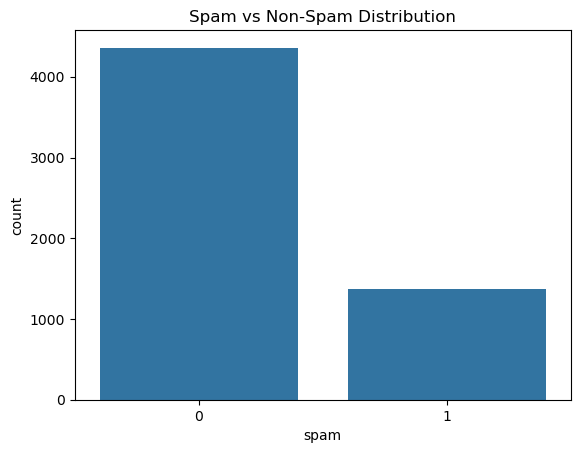

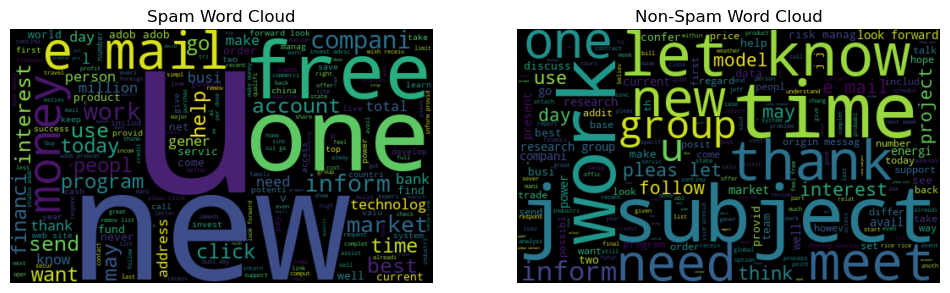

In [49]:
# Plot class distribution
sns.countplot(x=df["spam"])
plt.title("Spam vs Non-Spam Distribution")
plt.show()

# Generate word clouds
spam_words = " ".join(df[df["spam"] == 1]["processed_text"])
ham_words = " ".join(df[df["spam"] == 0]["processed_text"])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=300).generate(spam_words), interpolation="bilinear")
plt.title("Spam Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=300).generate(ham_words), interpolation="bilinear")
plt.title("Non-Spam Word Cloud")
plt.axis("off")

plt.show()


In [51]:
# TF-IDF Vectorizer with N-Grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)

# Transform text data
X = tfidf_vectorizer.fit_transform(df["processed_text"])
y = df["spam"]

print("TF-IDF Matrix Shape:", X.shape)  # (num_samples, num_features)


TF-IDF Matrix Shape: (5728, 5000)


In [53]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Create 50% spam class
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE, Spam Class Distribution:\n", pd.Series(y_resampled).value_counts())


After SMOTE, Spam Class Distribution:
 spam
0    4360
1    2180
Name: count, dtype: int64


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)


Training Set Size: (5232, 5000)
Test Set Size: (1308, 5000)


In [71]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Perform Grid Search
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train with best parameters
best_model = LogisticRegression(**best_params, class_weight='balanced')
best_model.fit(X_train, y_train)


Best Parameters: {'C': 10, 'solver': 'lbfgs'}


LogisticRegression(C=10, class_weight='balanced')

Accuracy: 0.9808868501529052
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       862
           1       0.96      0.99      0.97       446

    accuracy                           0.98      1308
   macro avg       0.98      0.98      0.98      1308
weighted avg       0.98      0.98      0.98      1308



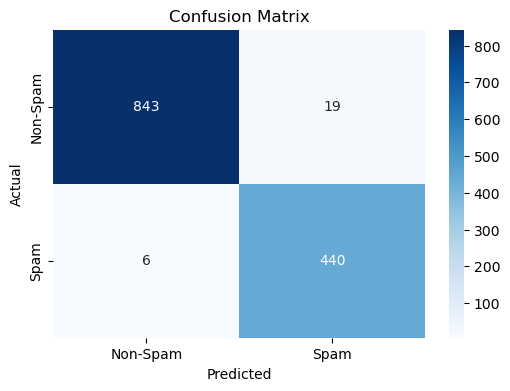

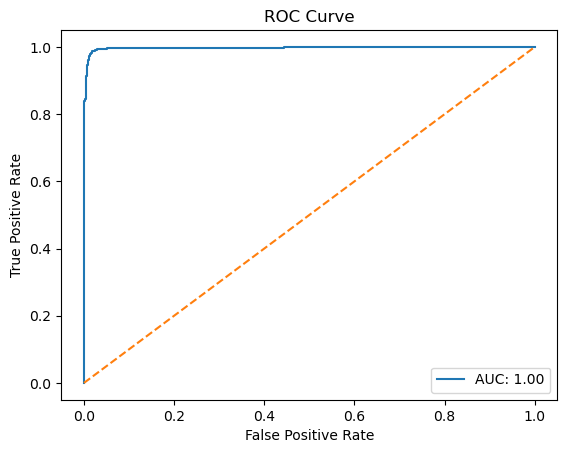

In [78]:
# Predictions
y_pred = best_model.predict(X_test)

# Model Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="AUC: {:.2f}".format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [81]:
import joblib
joblib.dump(best_model,'spam_classifier_model.pkl')
joblib.dump(tfidf_vectorizer,'tfdif_vectorizer.pkl')

['tfdif_vectorizer.pkl']